Pairwise t-tests vs Baseline saved.

Pairwise Total Reward t-tests vs Baseline:
Baseline vs PER Usage: t=-25.63, p=0.0000
Baseline vs Parallel Learning: t=-32.38, p=0.0000
Baseline vs EA Hyperparameters: t=-2.16, p=0.0582

Global Kruskal-Wallis test across all methods: H=33.64, p=0.0000

Post-hoc Dunn's test (Bonferroni corrected):
                    Baseline  EA Hyperparameters  PER Usage  Parallel Learning
Baseline            1.000000            1.000000   0.006013           0.000001
EA Hyperparameters  1.000000            1.000000   0.086121           0.000078
PER Usage           0.006013            0.086121   1.000000           0.334696
Parallel Learning   0.000001            0.000078   0.334696           1.000000


C:\Users\sanne\AppData\Local\Temp\ipykernel_28480\3759579512.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  long_data = pd.concat([long_data, df_temp], ignore_index=True)


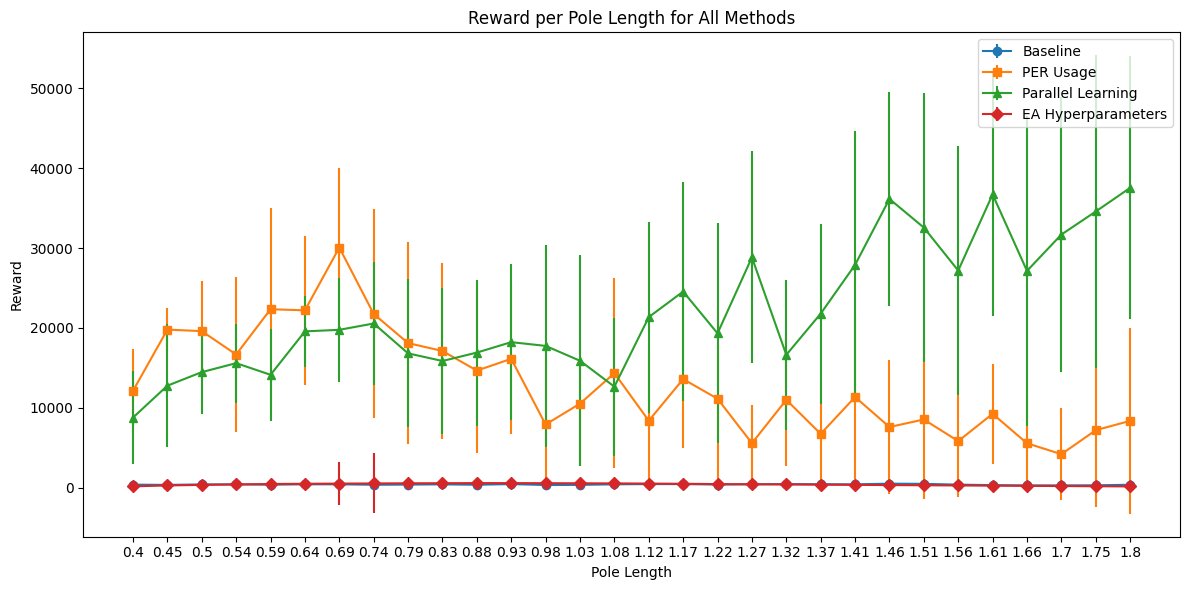

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import scikit_posthocs as sp

# --------------------------
# 1. Load Excel files
# --------------------------
files = {
    'Baseline': 'experiment_results_baseline2.xlsx',
    'PER Usage': 'experiment_results_perusagemodel.xlsx',
    'Parallel Learning': 'parallel_DQN_results.xlsx',
    'EA Hyperparameters': 'experiment_results_ea.xlsx'
}

data = {name: pd.read_excel(file) for name, file in files.items()}

# --------------------------
# 2. Extract pole lengths
# --------------------------
pole_lengths = [col.split('_')[1] for col in data['Baseline'].columns if 'Avg_' in col]

# --------------------------
# 3. Pairwise Welch's t-tests vs Baseline
# --------------------------
results_pairwise = []

for pole in pole_lengths:
    mean_b = data['Baseline'][f'Avg_{pole}'].values[0]
    std_b = data['Baseline'][f'Std_{pole}'].values[0]

    for method in files:
        if method == 'Baseline':
            continue

        mean_m = data[method][f'Avg_{pole}'].values[0]
        std_m = data[method][f'Std_{pole}'].values[0]

        # simulate 10 samples from mean/std
        np.random.seed(0)
        sample_b = np.random.normal(mean_b, std_b, 10)
        sample_m = np.random.normal(mean_m, std_m, 10)

        t_stat, p_value = stats.ttest_ind(sample_b, sample_m, equal_var=False)

        results_pairwise.append({
            'Pole_length': pole,
            'Comparison': f'Baseline vs {method}',
            't_stat': t_stat,
            'p_value': p_value,
            'Mean_Baseline': mean_b,
            'Mean_Method': mean_m
        })

results_df = pd.DataFrame(results_pairwise)
results_df.to_csv('pairwise_vs_baseline.csv', index=False)
print("Pairwise t-tests vs Baseline saved.")

# --------------------------
# 4. Overall Total reward per method
# --------------------------
# Simulate 10 samples per method from mean ± std
total_samples = {}
for name in files:
    # Sum of per-pole-length variances for total std
    total_std = np.sqrt(sum([data[name][f'Std_{p}'].values[0]**2 for p in pole_lengths]))
    total_mean = data[name]['Total'].values[0]
    np.random.seed(0)
    total_samples[name] = np.random.normal(total_mean, total_std, 10)

# Pairwise total t-tests vs Baseline
print("\nPairwise Total Reward t-tests vs Baseline:")
for method in files:
    if method == 'Baseline':
        continue
    t_stat, p_value = stats.ttest_ind(total_samples['Baseline'], total_samples[method], equal_var=False)
    print(f"Baseline vs {method}: t={t_stat:.2f}, p={p_value:.4f}")

# --------------------------
# 5. Global comparison with Kruskal-Wallis
# --------------------------
all_samples = [total_samples[name] for name in files]
h_stat, p_global = stats.kruskal(*all_samples)
print(f"\nGlobal Kruskal-Wallis test across all methods: H={h_stat:.2f}, p={p_global:.4f}")

# --------------------------
# 6. Post-hoc Dunn's test if Kruskal-Wallis significant
# --------------------------
if p_global < 0.05:
    # Convert to long format
    long_data = pd.DataFrame(columns=['Method', 'Reward'])
    for method in files:
        rewards = total_samples[method]
        df_temp = pd.DataFrame({'Method': [method]*len(rewards), 'Reward': rewards})
        long_data = pd.concat([long_data, df_temp], ignore_index=True)
    
    # Dunn's test
    dunn_result = sp.posthoc_dunn(long_data, val_col='Reward', group_col='Method', p_adjust='bonferroni')
    print("\nPost-hoc Dunn's test (Bonferroni corrected):")
    print(dunn_result)


# --------------------------
# 7. Plot per-pole-length with error bars
# --------------------------
plt.figure(figsize=(12,6))
markers = ['o', 's', '^', 'D']

for i, method in enumerate(files):
    means = [data[method][f'Avg_{p}'].values[0] for p in pole_lengths]
    stds = [data[method][f'Std_{p}'].values[0] for p in pole_lengths]
    plt.errorbar(pole_lengths, means, yerr=stds, label=method, marker=markers[i])

plt.xlabel('Pole Length')
plt.ylabel('Reward')
plt.title('Reward per Pole Length for All Methods')
plt.legend()
plt.tight_layout()
plt.savefig('reward_per_pole_length_all_methods.png')
plt.show()


In [ ]:
import pandas as pd
import glob
import os

# -------------------------------
# 1. Define paths and algorithms
# -------------------------------
# Each folder contains the 3 Excel files for one strategy
algorithms = {
    "Baseline": "path/to/baseline/files/*.xlsx",
    "PER_Usage": "path/to/per_usage/files/*.xlsx",
    "Parallel_Learning": "path/to/parallel_learning/files/*.xlsx",
    "EA_Hyperparameters": "path/to/ea_hyperparameters/files/*.xlsx"
}

# Dictionary to store combined DataFrames
combined_data = {}

# -------------------------------
# 2. Combine Excel files per algorithm
# -------------------------------
for algo, path_pattern in algorithms.items():
    all_files = sorted(glob.glob(path_pattern))  # Sort to assign run numbers consistently
    df_list = []

    for i, file in enumerate(all_files):
        df = pd.read_excel(file)
        df = df.melt(var_name='Pole_Length', value_name='Reward')  # Convert wide -> long
        df['Training_Run'] = i + 1
        df['Algorithm'] = algo
        df_list.append(df)
    
    combined_data[algo] = pd.concat(df_list, ignore_index=True)

# -------------------------------
# 3. Merge all algorithms into one DataFrame
# -------------------------------
all_data = pd.concat(combined_data.values(), ignore_index=True)

# Clean up pole length column (remove 'Avg_' or 'Std_' prefixes if needed)
all_data['Pole_Length'] = all_data['Pole_Length'].str.replace(r'Avg_|Std_', '', regex=True).astype(float)

# -------------------------------
# 4. Compute per-pole-length mean & SD
# -------------------------------
summary = all_data.groupby(['Algorithm', 'Pole_Length'])['Reward'].agg(['mean', 'std']).reset_index()
print(summary.head())

# -------------------------------
# 5. Compute total/average reward per training run
# -------------------------------
total_rewards = all_data.groupby(['Algorithm', 'Training_Run'])['Reward'].sum().reset_index()
print(total_rewards.head())

# -------------------------------
# 6. Prepare for statistical tests
# -------------------------------
# Example: Per-pole-length Welch's t-tests vs Baseline
from scipy.stats import ttest_ind

baseline_data = all_data[all_data['Algorithm'] == 'Baseline']

results = []
pole_lengths = all_data['Pole_Length'].unique()
for pole in pole_lengths:
    baseline_rewards = baseline_data[baseline_data['Pole_Length'] == pole]['Reward']
    for algo in algorithms:
        if algo == 'Baseline':
            continue
        algo_rewards = all_data[(all_data['Algorithm'] == algo) & (all_data['Pole_Length'] == pole)]['Reward']
        t_stat, p_val = ttest_ind(baseline_rewards, algo_rewards, equal_var=False)  # Welch's t-test
        results.append({
            'Pole_Length': pole,
            'Comparison': f'Baseline vs {algo}',
            't_stat': t_stat,
            'p_value': p_val,
            'Mean_Baseline': baseline_rewards.mean(),
            'Mean_Method': algo_rewards.mean()
        })

results_df = pd.DataFrame(results)
print(results_df.head())

# -------------------------------
# 7. Prepare data for Kruskal-Wallis (aggregate across pole lengths)
# -------------------------------
from scipy.stats import kruskal

aggregate = total_rewards.pivot(index='Training_Run', columns='Algorithm', values='Reward')
stat, p = kruskal(*[aggregate[col].values for col in aggregate.columns])
print(f"Kruskal-Wallis H={stat}, p={p}")

# -------------------------------
# 8. Optional: Post-hoc Dunn's test
# -------------------------------
import scikit_posthocs as sp

# Melt aggregate for Dunn's test
dunn_input = aggregate.melt(var_name='Algorithm', value_name='Total_Reward')
dunn_result = sp.posthoc_dunn(dunn_input, val_col='Total_Reward', group_col='Algorithm', p_adjust='bonferroni')
print(dunn_result)
